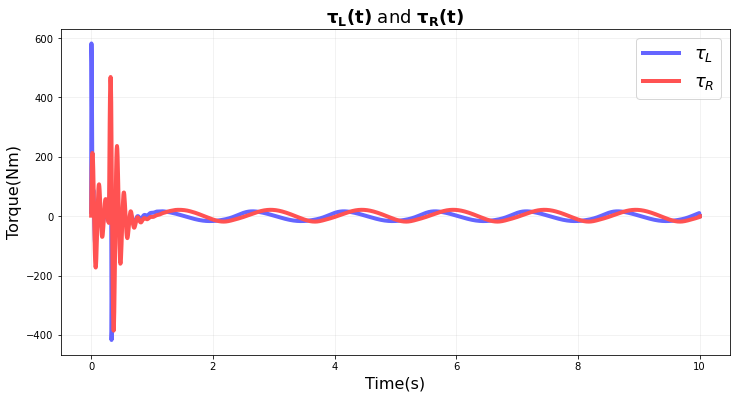

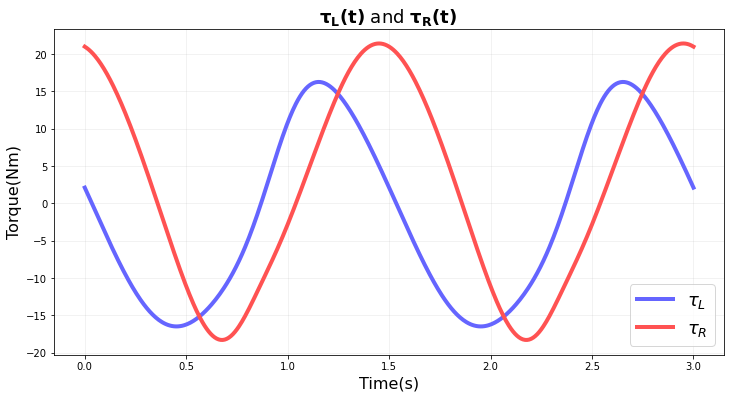

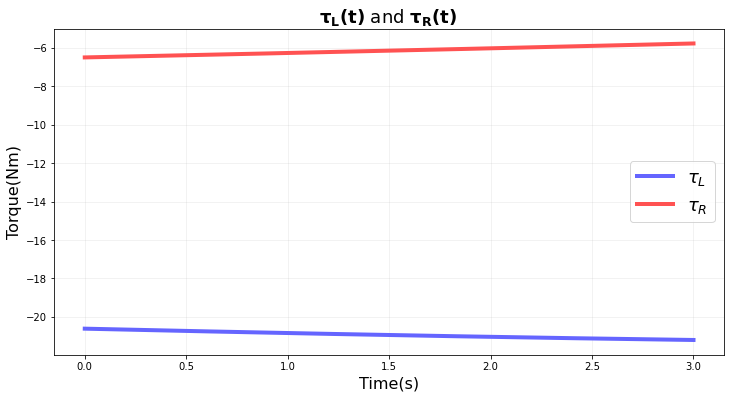

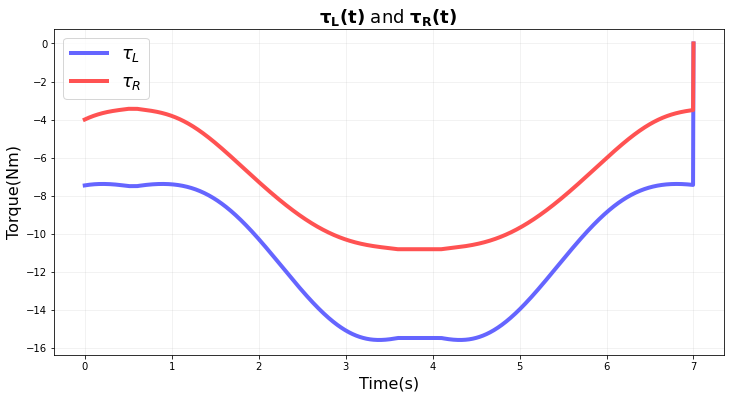

# milestones

* create a function that takes an x,y location, an amplitude, a cyclical frequency, and performs the simulation and returns max torques for motor 1 and motor 2 after an assumed stabilization period x
* have another function that samples the space, and if the IK solves, run's function 1
* for each point, you want to keep pushing the speed, until you saturate one of the motor torques. this is then the max frequency. but what's the best way to do this? it's something like newton rhapson, to find the root of f(x) - 100. 
* have a last function, written in plotly that makes contour plot of this "bandwidth" vs. position, for a particular model payload. 


vision statement for the plot. 

* so it appears that the calculation of the full dynamics is going to be rather expensive, so we will need to calculate this once, and cache it for plotting



In [5]:
import os
import h5py

#extract data from disk
cwd = os.getcwd()
freqDataName = "freq_" + str(.01) + "_" +  str(20) + "_gravity"
f = h5py.File(cwd + "\\data\\" + "_workspaceFreqData" + ".hdf5" , "a")
xs = f["x"]
ys = f["y"]
freq = f[freqDataName]

    

<HDF5 dataset "freq_0.01_20_gravity": shape (100,), type "<f8">

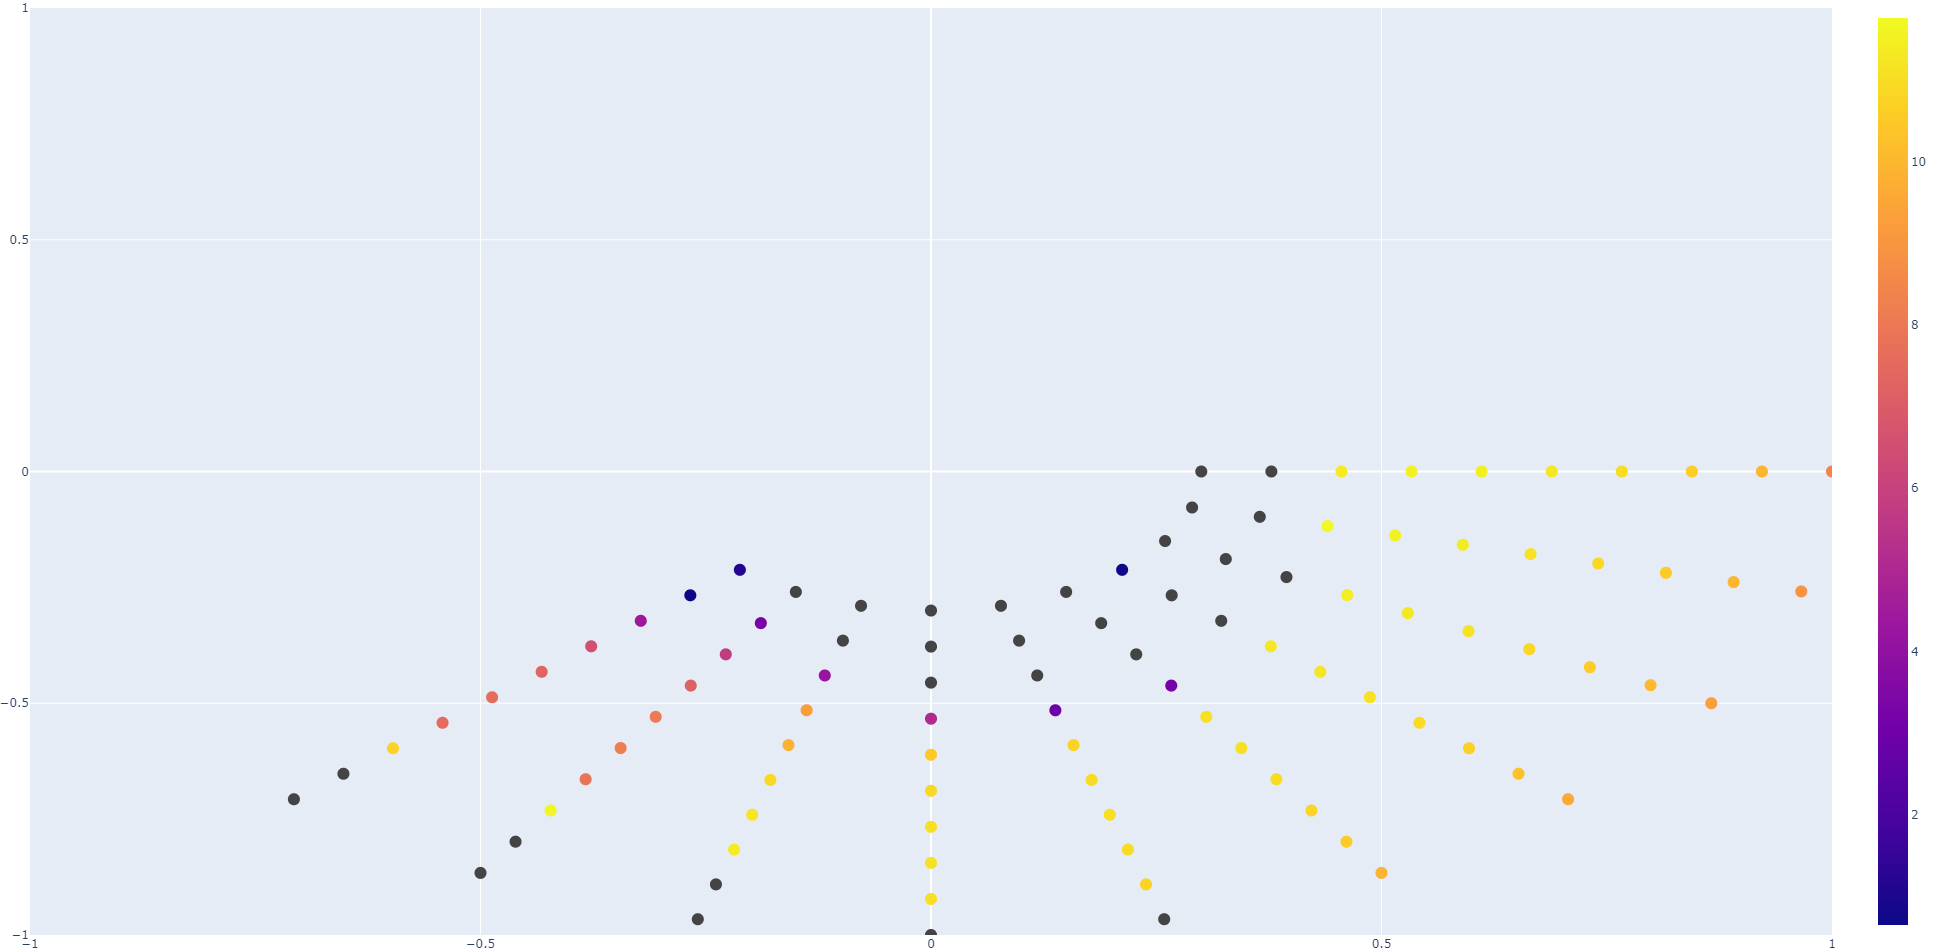

In [8]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon


#plot frequency data
#mode = "contour" 
mode = "scatter"

#setup plot 
Sfig = go.FigureWidget()

#configure layout of graph
Sfig.update_xaxes(range=[-1,1])
Sfig.update_yaxes(range=[-1,1])

Sfig.update_layout(
    autosize=False,
    width =1050,
    height=950,
    legend=dict(x=.025, y=.975),
    margin=dict(l=0, r=20, t=0, b=0))


Sfig.add_scatter(mode="markers", marker = dict(size=10.1,color = np.linspace(0,1,100),showscale=True),name="Sample")

Sfig.data[0]['marker']['color'] = freq
Sfig.data[0]['x'] = xs
Sfig.data[0]['y'] = ys
Sfig.data[0]['marker']['size'] = 12

Sfig.show()


In [ ]:
#from scipy.interpolate import griddata
from IPython.display import display
from ipywidgets import AppLayout




class torqueSatVis:
    """
    provides joint visualization functionality for viewing the results
    of numerical optimization experiements
    """
    def __init__(self,exp):
        
        #reference to model objects
        self.exp = exp
        r = exp.r ; self.r = r
        h = exp.h ; self.h = h
        
        #------------------------------ plot configuration --------------------------------------
        #setup plot 
        Sfig = go.FigureWidget()

        #configure layout of graph
        Sfig.update_xaxes(range=[-1,1])
        Sfig.update_yaxes(range=[-1,1])

        Sfig.update_layout(
            autosize=False,
            width =1050,
            height=950,
            legend=dict(x=.025, y=.975),
            margin=dict(l=0, r=20, t=0, b=0))
        

        
        #add score annotation
        Sfig.add_annotation(
                x= .9,
                y= .95,
                xref="paper",
                yref="paper",
                text="",
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="#ffffff"
                    ),
                align="center",
                ax=0,
                ay=0,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8
                )
        
        #add objective Fxn annotation 
        Sfig.add_annotation(
                x= .88,
                y= .05,
                xref="paper",
                yref="paper",
                text="",
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="#ffffff"
                    ),
                align="center",
                ax=0,
                ay=0,
                bordercolor="#482878",
                borderwidth=2,
                borderpad=4,
                bgcolor="#33b579",
                opacity=0.8
                )

        
        #placeholder
        Sfig.add_scatter(line=dict(color='gray'), name = "placeholder")
        
        #Robot plots
        Sfig.add_scatter(line=dict(color='gray'), name = "left")
        Sfig.add_scatter(line=dict(color='red'), name = "right")
        Sfig.add_scatter(fill='tozeroy',fillcolor='rgba(225, 0, 0, .2)',mode= 'none'  ,name="Robot forceSpace")

        #human plots
        Sfig.add_scatter(line=dict(dash='dash',color='blue'), name = "workspace")
        Sfig.add_scatter(mode="markers", marker = dict(size=10.1,color = np.linspace(0,1,50*25),showscale=True),name="Sample")
        Sfig.add_scatter(line=dict(color='blue',width=4),name = "leg")
        Sfig.add_scatter(mode='markers', marker=dict(size=12,color="black"), name = "End Effector")
        Sfig.add_scatter(fill='toself', fillcolor='rgba(0,0,256,.2)', mode= 'none', name="Human force Space")


        #setup UI
        
        #layouts and configurations
        layout   = Layout(width='305px', height='20px')
        layout1 = Layout(width='100px', height='30px')
        layout1a = Layout(width='200px', height='30px')
        leftTab  = Layout(width='100px', height='30px',margin = '2px 0px 0px 60px')
        leftTab1 = Layout(width='100px', height='30px',margin = '2px 0px 0px 40px')
        topMargin= Layout(margin = '7px 0px 0px 0px')
        lmin = .1 ; lmax = .75; lval = .25
        rng = 1; step = .001

        #modes
        reset = widgets.Button(description='Reset',disabled=False,button_style='success',tooltip='reset x state',layout = leftTab)
        fsView = Checkbox(value=False,description="fsView",indent=False,layout=leftTab1)
        sample = Checkbox(value=False,description="sample",indent=False,layout=layout1)
        sampNorm = Checkbox(value=False,description="sampNorm",indent=False,layout=layout1)
        workspace = Checkbox(value=False,description="workspace",indent=False,layout=layout1)


        #drivers
        xee = FloatSlider(min=-rng,max=rng,step=step,value= .5,description='xee', layout=layout)
        yee = FloatSlider(min=-rng,max=rng,step=step,value=-.5,description='yee', layout=layout)

        #scales
        fsScale    = FloatSlider(min=.01,max=1,step=step,value=.5,description='fsScale', layout=layout)
        markerSize = FloatSlider(min=1,max=24,step=step,value=24,description='MarkerSize', layout=layout)
        
        #solution number
        n = widgets.IntSlider(min=0,max=1,step=1,value=0,description='Sol Num:', layout=layout)

        #params
        tuneLabel = widgets.Label(value="Tune Optimal Parameters:")
        ef = Dropdown(options=["up","down"],value=r.ef,description='ef',layout=layout1a)
        e3 = Dropdown(options=["up","down"],value=r.e3,description='e3',layout=layout1a)

        L1l = FloatSlider(min=r.L1l_min,max=r.L1l_max,step=step,value=r.L1l,description='L1_l', layout=layout)
        L2l = FloatSlider(min=r.L2l_min,max=r.L2l_max,step=step,value=r.L2l,description='L2_l', layout=layout)
        L3l = FloatSlider(min=r.L3l_min,max=r.L3l_max,step=step,value=r.L3l,description='L3_l', layout=layout)

        L1r = FloatSlider(min=r.L1r_min,max=r.L1r_max,step=step,value=r.L1r,description='L1_r', layout=layout)
        L2r = FloatSlider(min=r.L2r_min,max=r.L2r_max,step=step,value=r.L2r,description='L2_r', layout=layout)
        θ3l = FloatSlider(min=r.θ3l_min,max=r.θ3l_max,step=step,value=r.θ3l,description='θ3_l', layout=layout)

        xl = FloatSlider(min=r.xl_min,max=r.xl_max,step=step,value=r.xl,description='x_l', layout=layout)
        xr = FloatSlider(min=r.xr_min,max=r.xr_max,step=step,value=r.xr,description='x_r', layout=layout)

        yl = FloatSlider(min=r.yl_min,max=r.yl_max,step=step,value=r.yl,description='y_l', layout=layout)
        yr = FloatSlider(min=r.yr_min,max=r.yr_max,step=step,value=r.yr,description='y_r', layout=layout)
        
        τl = FloatSlider(min=r.τ1l_min,max=r.τ1l_max,step=1,value=r.τ1l,description='τl', layout=layout)
        τr = FloatSlider(min=r.τ1r_min,max=r.τ1r_max,step=1,value=r.τ1r,description='τr', layout=layout)
        
        #assemble UI
        row1 = widgets.HBox([reset,fsView,sample,sampNorm,workspace],layout=topMargin)
        row2 = widgets.HBox([xee,markerSize])
        row3 = widgets.HBox([yee,fsScale])
        row4 = widgets.HBox([n])

        row5 = widgets.HBox([tuneLabel])
        row6 = widgets.HBox([ef,e3])
        row7 = widgets.HBox([L1l,L1r])
        row8 = widgets.HBox([L2l,L2r])
        row9 = widgets.HBox([L3l,θ3l])
        row10 = widgets.HBox([xl,xr])
        row11 = widgets.HBox([yl,yr])
        row12 = widgets.HBox([τl,τr])

        ui1 =  widgets.VBox([row1,row2,row3,row4])
        ui2 =  widgets.VBox([row5,row6,row7,row8,row9,row10,row11,row12])


        #setup update function wdict
        wdict = {"fsView":fsView,"sample":sample,"sampNorm":sampNorm,"workspace":workspace,
                 "xee":xee, "markerSize":markerSize,
                 "yee":yee, "fsScale":fsScale,
                 "n":n,
                 "ef":ef,"e3":e3,
                 "L1l":L1l,"L2l":L2l,"L3l":L3l,
                 "L1r":L1r,"L2r":L2r,"θ3l":θ3l,
                 "xl":xl,"xr":xr,
                 "yl":yl,"yr":yr,
                 "τl":τl,"τr":τr}
        
        
        #register the callback function for reset press
        reset.on_click(self.reset_callback)
        
        #persist objects by keeping a reference to them
        self.Sfig = Sfig
        self.ui1 = ui1
        self.ui2 = ui2
        self.wdict = wdict
        self.resetFlag = False
        self.nPrev = 0
    
    
    #------------------------------ functions -------------------------------
    def reset_callback(self,b):
        self.resetFlag = True
        #trigger callback 
        self.wdict['xee'].value = self.wdict['xee'].value + .0001  
        print("set to optimal configuration")
    
    def colorSamples(self,scores):
        """
        for the particular robot state, color the human samples based on
        the value of the objective function at that point.
        """
        return scores
        
    
    def update(self,fsView=False,sample=False,sampNorm=False,workspace=False,
               xee=1,markerSize=12,
               yee=1,fsScale=1,
               n=1,
               ef="up",e3="up",
               L1l=1,L2l=1,L3l=1,
               L1r=1,L2r=1,θ3l=1,
               xl=0,xr=1,
               yl=0,yr=1,
               τl=1,τr=1):
        
        
        #localize all object vars
        r = self.r
        h = self.h
        exp = self.exp
        Sfig = self.Sfig
        
        
        with Sfig.batch_update():

            fsScaleStatic = .001  
            #---------------------- robot --------------------------
            #update robot parameter values based on widgets
            if not self.resetFlag:
                r.ef = ef ; r.e3 = e3
                r.L1l = L1l ; r.L2l=L2l ; r.L3l = L3l
                r.L1r = L1r ; r.L2r=L2r ; r.θ3l = θ3l
                r.xl = xl ; r.xr = xr
                r.yl = yl ; r.yr = yr
                r.τ1l = τl; r.τ1r = τr

            #reset robot to optimal location if reset clicked, or n is moved
            if self.resetFlag or n is not self.nPrev:
                self.wdict['n'].max = len(self.exp.xBest) - 1  #num of solutions
                xBest = self.exp.xBest[n]
                self.r.set_x(xBest)
                
                self.wdict['L1l'].value = r.L1l
                self.wdict['L2l'].value = r.L2l 
                self.wdict['L3l'].value = r.L3l 

                self.wdict['L1r'].value = r.L1r 
                self.wdict['L2r'].value = r.L2r 
                self.wdict['θ3l'].value = r.θ3l

                self.wdict['xl'].value = r.xl
                self.wdict['xr'].value = r.xr

                self.wdict['yl'].value = r.yl
                self.wdict['yr'].value = r.yr 
                
                self.resetFlag = False
                self.nPrev = n
                
            #calculate the IK
            _θ1l,_θ2l,_θ3l,_θ1r,_θ2r = r.IK5bl(xee,yee)
            left,right = r.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)

            #draw the robot (if solution exists)
            Sfig.data[1]['x'] = left[0]
            Sfig.data[1]['y'] = left[1]

            Sfig.data[2]['x'] = right[0]
            Sfig.data[2]['y'] = right[1]  

            #draw the force space 
            if fsView:
                xs,ys = r.FSplot(xee,yee,fsScale * fsScaleStatic)
                Sfig.data[3]['x'] = xs + xee
                Sfig.data[3]['y'] = ys + yee

            else:
                Sfig.data[3]['x'] = []
                Sfig.data[3]['y'] = []


            #-------------------- human -----------------------------
            #draw the boundry
            if workspace:
                xs,ys = h.reachableSpacePlot()
                Sfig.data[4]['x'] = xs
                Sfig.data[4]['y'] = ys
            else:
                Sfig.data[4]['x'] = []
                Sfig.data[4]['y'] = []

            #draw the human leg
            θh,θk,θa = h.IK(xee,yee)
            xs,ys = h.FKplot(θh,θk,θa)
            Sfig.data[6]['x'] = xs
            Sfig.data[6]['y'] = ys

            #draw the end effect location
            Sfig.data[7]['x'] = [xee]
            Sfig.data[7]['y'] = [yee]


            #draw the force space
            if fsView:
                xs,ys = h.FSplot(xee,yee,fsScale * fsScaleStatic)
                Sfig.data[8]['x'] = xs + xee
                Sfig.data[8]['y'] = ys + yee
            else:
                Sfig.data[8]['x'] = []
                Sfig.data[8]['y'] = []


            #--------------------- joint ---------------------------
             #draw objective fxn sample 
            if sample:
                scores = self.exp.scoreSamplePoints(r.get_x())
                colors = self.colorSamples(scores)       
                xs,ys = h.samplePoints[:,0],h.samplePoints[:,1]  
                Sfig.data[5]['marker']['color'] = colors
                Sfig.data[5]['x'] = xs
                Sfig.data[5]['y'] = ys
                Sfig.data[5]['marker']['size'] = markerSize
                
            elif not sample:
                Sfig.data[5]['x'] = []
                Sfig.data[5]['y'] = []

                
            #annotate the score of the current configuration
            hpoly = h.FSpolygon(xee,yee)
            rpoly = r.FSpolygon(xee,yee)
            score =  exp.score(hpoly,rpoly)
            Sfig.layout['annotations'][0]['text'] =  "score = " + str(round(score,3))
            
            #annotate the value of the objective function 
            if sample:ts = np.sum(scores)
            else: ts = exp.objective(r.get_x())
            Sfig.layout['annotations'][1]['opacity'] = .8 #turn on visibility
            Sfig.layout['annotations'][1]['text'] =  "obj fxn = " + str(round(ts,3))
                

    def display(self,dispMode = "lr"):
        
        #display interactive figure
        self.out = widgets.interactive_output(self.update, self.wdict)
        if dispMode == "lr":
            self.Sfig.layout.width  = 1050   #incase this got changed
            self.Sfig.layout.height = 950    #from a previous display call
            rtSide = AppLayout(header=self.ui1,
                               left_sidebar=None,
                               center=widgets.HBox([]),
                               right_sidebar=None,
                               footer=self.ui2,
                               pane_heights=[3,'60px',1])
            sideBySide = widgets.HBox([self.Sfig,rtSide])
            display(sideBySide)
            
        #might want to display that works when display is minimized
        elif dispMode == "tb":
            self.Sfig.layout.width  = 725
            self.Sfig.layout.height = 600 
            display(self.ui1)
            display(self.Sfig)
            display(self.ui2)

